In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
from pathlib import Path
import os
from scipy import linalg

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls drive/MyDrive/NN_MEFs/

 CAISO_Data_2019_2021_NN_Ts.csv   FF_models	   mlp_non_bottleneck_models
'Experiment notes.gdoc'		  MLP_MEFs.ipynb


## Parameters

In [5]:
work_dir = "drive/MyDrive/NN_MEFs"
data_file = f"{work_dir}/CAISO_Data_2019_2021_NN_Ts.csv"
model_save_dir = f"{work_dir}/mlp_non_bottleneck_models"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_out = 1  # just predicting d_emission directly

## data exploration

In [6]:
data_df = pd.read_csv(data_file)

In [7]:
data_df.head()

,Unnamed: 0,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,...,Hour,Month,Day,Pas_Temp,SJ_Temp,NH_Temp,SB_Temp,Sac_Temp,Fres_Temp,LB_Temp
0,2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,...,0,1,1,49.2,33.6,50.7,46.3,33.9,54.9,54.9
1,2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,...,1,1,1,42.7,30.7,49.8,45.6,34.1,54.0,54.0
2,2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,...,2,1,1,40.4,30.1,50.3,45.1,32.7,52.8,52.8
3,2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,...,3,1,1,39.2,29.1,47.2,44.4,32.1,52.6,52.6
4,2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,...,4,1,1,37.6,28.4,42.5,44.3,31.4,52.0,52.0


## Data Loading and pre-processing

In [16]:
# read in the processed data. there should be zero nans or missing data.
CAISO_Data = pd.read_csv(data_file, index_col=0)
CAISO_Data.index = pd.to_datetime(CAISO_Data.index)

### Feature engineering...

## Temporal features
CAISO_Data.loc[:,"Day_of_Year"] = [instant.timetuple().tm_yday for instant in CAISO_Data.index]
# CAISO_Data.loc[:,"Is_Weekend"] = [instant.weekday() > 4 for instant in CAISO_Data.index]
# for day_of_week in range(7):
#     CAISO_Data.loc[:,f"Day_of_Week={day_of_week}"] = [instant.weekday() ==day_of_week for instant in CAISO_Data.index]

## Recent history features
prev_time_steps = [1,2]#,24]#,3]
for i in prev_time_steps:
    # CAISO_Data.loc[:,f"Load_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"Load"])
    # CAISO_Data.loc[:,f"VRE_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"VRE"])
    CAISO_Data.loc[:,f"d_emissions_t-{i}"] = ([np.nan] * i) + list(CAISO_Data.iloc[:-i].loc[:,"delta_Total_CO2_Emissions"])
# Drop rows that don't have all prev-time-step features
CAISO_Data = CAISO_Data.iloc[max(prev_time_steps):]


## load and VRE derivatives
# CAISO_Data.loc[:,"Load_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"Load"].values - CAISO_Data.iloc[:-1].loc[:,"Load"].values)
# CAISO_Data.loc[:,"Load_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"Load_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"Load_d1"].values)
# CAISO_Data.loc[:,"VRE_d1"] = [np.nan] + list(CAISO_Data.iloc[1:].loc[:,"VRE"].values - CAISO_Data.iloc[:-1].loc[:,"VRE"].values)
# CAISO_Data.loc[:,"VRE_d2"] = [np.nan, np.nan] + list(CAISO_Data.iloc[2:].loc[:,"VRE_d1"].values - CAISO_Data.iloc[1:-1].loc[:,"VRE_d1"].values)
# # Drop rows that don't have all features
# CAISO_Data = CAISO_Data.iloc[2:]


num_samples = len(CAISO_Data)

# create masks for train, validation and test data
percent_train, percent_val, percent_test = .6, .2, .2
num_train, num_val = int(percent_train * num_samples), int(percent_val * num_samples)
num_test = num_samples - num_train - num_val
set_assignments = np.array([1 for i in range(num_train)] + [2 for i in range(num_val)] + [3 for i in range(num_test)])
np.random.seed(1)
np.random.shuffle(set_assignments)
train_mask = set_assignments == 1
val_mask = set_assignments == 2
test_mask = set_assignments == 3
CAISO_train = CAISO_Data.loc[train_mask]
CAISO_val = CAISO_Data.loc[val_mask]
CAISO_test = CAISO_Data.loc[test_mask]

## old features we've tried
# feature_cols = ['Load', 'VRE', 'Hour', 'Month', 'Day', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Is_Weekend', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year', 'Pas_Temp', 'SJ_Temp', 'NH_Temp', 'SB_Temp', 'Sac_Temp', 'Fres_Temp', 'LB_Temp']
# feature_cols.extend([f"Day_of_Week={day_of_week}" for day_of_week in range(7)])

feature_cols = ['Load', 'VRE', 'Hour', 'Day_of_Year']
feature_cols.extend(["delta_Load", "delta_VRE"])
# feature_cols.extend([f"Load_t-{i}" for i in prev_time_steps] + [f"VRE_t-{i}" for i in prev_time_steps])
# feature_cols.extend(["Load_d1", "Load_d2", "VRE_d1", "VRE_d2"])
# feature_cols.extend(["delta_Load", "delta_VRE"])
feature_cols.extend([f"d_emissions_t-{i}" for i in prev_time_steps])


# specify x and y data #TODO seems like there may be some unnecessary operations here... 
train_x = torch.tensor(CAISO_train[feature_cols].values.astype(np.float32))
val_x = torch.tensor(CAISO_val[feature_cols].values.astype(np.float32))
test_x = torch.tensor(CAISO_test[feature_cols].values.astype(np.float32))
train_y = torch.unsqueeze(torch.tensor(np.array(CAISO_train['delta_Total_CO2_Emissions'].values).astype(np.float32)), 1)
val_y = torch.unsqueeze(torch.tensor(np.array(CAISO_val['delta_Total_CO2_Emissions'].values).astype(np.float32)), 1)
test_y = torch.unsqueeze(torch.tensor(np.array(CAISO_test['delta_Total_CO2_Emissions'].values).astype(np.float32)), 1)


# standardize data based on mean and variance of train data
# scaler = preprocessing.StandardScaler()
# scaler.fit(train_x)
# train_x = torch.tensor(scaler.transform(train_x)).to(device)
# val_x = torch.tensor(scaler.transform(val_x)).to(device)
# test_x = torch.tensor(scaler.transform(test_x)).to(device)

# alternatively, we can whiten which will standardize and decorrelate
# Code here taken from stack overflow
def get_whitening_matrix(X):
    # X.shape = (examples, features)
   X_cov = np.dot(X.T,X)
   # eigenvalue decomposition of the covariance matrix
   d, V = np.linalg.eigh(X_cov)
   # a fudge factor can be used so that eigenvectors associated with
   # small eigenvalues do not get overamplified.
   D = np.diag(1. / np.sqrt(d+1e-18))
   # whitening matrix
   W = np.dot(np.dot(V, D), V.T)
   return W

train_mean = torch.mean(train_x, axis=0)
# zero center data first
train_x = train_x - train_mean
val_x = val_x - train_mean
test_x = test_x - train_mean
whitening_mat = get_whitening_matrix(train_x)
train_x = torch.tensor(np.dot(train_x, whitening_mat)).to(device)
val_x = torch.tensor(np.dot(val_x, whitening_mat)).to(device)
test_x = torch.tensor(np.dot(test_x, whitening_mat)).to(device)


In [9]:
train_y.shape

torch.Size([15781, 1])

In [10]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Pas_Temp,SJ_Temp,NH_Temp,SB_Temp,Sac_Temp,Fres_Temp,LB_Temp,Day_of_Year,d_emissions_t-1,d_emissions_t-2
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-1.448468e+05,-20.952957,...,40.4,30.1,50.3,45.1,32.7,52.8,52.8,1,-243021.833700,-337029.794143
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-2.477657e+04,-2.164379,...,39.2,29.1,47.2,44.4,32.1,52.6,52.6,1,-144846.797503,-243021.833700
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,4.925414e+04,69.703951,...,37.6,28.4,42.5,44.3,31.4,52.0,52.0,1,-24776.569759,-144846.797503
2019-01-01 05:00:00,20788.250000,18657.333333,5.121183e+06,683.373182,2463.943924,2130.916667,461.166667,644.666667,8.875969e+04,-28.538786,...,41.8,27.4,39.7,44.5,30.3,51.9,51.9,1,49254.136541,-24776.569759
2019-01-01 06:00:00,21543.083333,19472.083333,6.223157e+06,858.643441,3465.608809,2070.916667,754.833333,814.750000,1.101974e+06,175.270260,...,48.8,28.0,38.7,43.7,28.6,50.1,50.1,1,88759.691104,49254.136541


In [18]:
train_x.shape

torch.Size([15781, 8])

## define model and set params

In [19]:
def get_model(n_input, hidden_dims, n_out, dropout_p):
    
    layers = [nn.Linear(n_input, hidden_dims[0]),
              nn.BatchNorm1d(hidden_dims[0]),
              nn.ReLU(),
              nn.Dropout(dropout_p)
             ]
    for layer in range(len(hidden_dims)-1):
        cur_hidden, next_hidden = hidden_dims[layer], hidden_dims[layer+1]
        layers.extend([nn.Linear(cur_hidden, next_hidden),
                       nn.BatchNorm1d(next_hidden),
                       nn.ReLU(),
                       nn.Dropout(dropout_p)
                      ])
    layers.append(nn.Linear(hidden_dims[-1], n_out))
    
    model = nn.Sequential(*layers)
    return model

## Model Training

Helpers for printing results

In [20]:
pd.options.mode.chained_assignment = None  # default='warn'

In [21]:
def print_results(train_losses, train_preds, train_y, val_losses, val_preds, val_y, plt_save_dir=None):
    #plot loss vs epochs
    fig, axs = plt.subplots(1,2)
    axs[0].plot(train_losses[1000:])
    axs[0].set_title("Train Set")
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')

    axs[1].plot(val_losses[1000:])
    axs[1].set_title("Val Set")
    axs[1].set_ylabel('loss')
    axs[1].set_xlabel('epoch')
    
    plt.tight_layout()
    plt.show()
    
    if plt_save_dir:
        fig.savefig(f"{plt_save_dir}/train_val_losses.png") 

    #calculate some error stuff. rn i am thinking R2 is the best measure of error
    print("Train Set:")
    print(f"\tMean Emissions Change = {torch.mean(torch.abs(train_y)).item():.2f}")
    print(f"\tMean Error = {torch.mean(torch.abs(train_preds - train_y)).item():.2f}")
    print(f"\tR Squared = {r2_score(train_y.detach().numpy(), train_preds.detach().numpy()):.4f}")
    
    print("Val Set:")
    print(f"\tMean Emissions Change = {torch.mean(torch.abs(val_y)).item():.2f}")
    print(f"\tMean Error = {torch.mean(torch.abs(val_preds - val_y)).item():.2f}")
    print(f"\tR Squared = {r2_score(val_y.detach().numpy(), val_preds.detach().numpy()):.4f}")

Train the model

In [22]:
def train_model_with_params(train_x, val_x, train_y, val_y, n_out, hidden_dims, learning_rate, weight_decay, dropout_p, \
                            loss_function, model_dir_prefix=None, epochs=10000):
    
    print(f"Model Params: hidden_dims={','.join(str(dim) for dim in hidden_dims)}, learning_rate={learning_rate}, weight_decay={weight_decay}, dropout={dropout_p}" \
          + f", loss_function={loss_function}")
    n_input = train_x.shape[1]
    print(f"num input features: {n_input}")
    print("Features:")
    print("\t" + ", ".join(feature_cols))
    model = get_model(n_input, hidden_dims, n_out, dropout_p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    model_dir = model_save_dir
    if model_dir_prefix:
        model_dir += f"/{model_dir_prefix}"
    model_dir += f"/hidden={','.join(str(dim) for dim in hidden_dims)}," \
              + f"LR={learning_rate},w_decay={weight_decay},dropout={dropout_p}"
    
    Path(model_dir).mkdir(parents=True, exist_ok=True)

    with open(f"{model_dir}/experiment_settings.txt", 'w+') as f:
        f.write("Model Params:")
        f.write(f"\thidden_dims={','.join(str(dim) for dim in hidden_dims)}")
        f.write(f"\tlearning_rate={learning_rate}")
        f.write(f"\tweight_decay={weight_decay}")
        f.write(f"\tdropout={dropout_p}")
        f.write(f"\tloss_function={loss_function}")
        f.write("Features:")
        f.write("\t" + ", ".join(feature_cols))

    model.to(device)

    min_save_r2 = .80 # Don't save model unless gets above this value as we know we can do this well.
    best_r2 = -np.inf
    best_model_mae = -np.inf
    best_epoch = None
    save_model_path = None
    last_save_epoch = None
    
    train_losses = []
    val_losses = []
    for epoch in tqdm(range(epochs)):
        # tell model we are training (for bathnorm layer, dropout...)
        model.train()
        train_preds=model(train_x.float()).cpu()
        train_loss=loss_function(train_preds, train_y)
        train_losses.append(train_loss.item())
        
        # tell model we are evaluating
        model.eval()
        val_preds=model(val_x.float()).cpu()
        val_loss=loss_function(val_preds, val_y)
        val_losses.append(val_loss.item())
        val_r2 = r2_score(val_y.detach().numpy(), val_preds.detach().numpy())

        # always keep best r2 updated
        if val_r2 > best_r2:
            best_r2 = val_r2
            best_model_mae = mean_absolute_error(val_y.detach().numpy(), val_preds.detach().numpy())
            best_epoch = epoch
            if val_r2 > min_save_r2:
                if save_model_path:
                    Path(save_model_path).unlink() # delete prev-best model
                model_save_name = f"epoch={epoch},r2={val_r2:.4f}.pth"
                save_model_path = f"{model_dir}/{model_save_name}"
                torch.save(model.state_dict(), save_model_path)
                last_save_epoch = epoch
        
        if epoch % 1000 == 0:
            train_r2 = r2_score(train_y.detach().numpy(), train_preds.detach().numpy())
            print(f"[Epoch {epoch}] " \
                  + f"\tTrain Set: Loss={train_loss.item():.3e}, R Squared={train_r2:.4f}\t" \
                  + f"Val Set: Loss={val_loss.item():.3e}, R Squared={val_r2:.4f}")
            
        model.zero_grad()
        train_loss.backward()
        optimizer.step()

        # stop if we aren't improving after 10k epochs
        if best_epoch and epoch > 10000 + best_epoch:
            print("Early stopping as we haven't made an improvement on validation set in 10,000 epochs.")
            break

    print_results(train_losses, train_preds, train_y, val_losses, val_preds, val_y, model_dir)
    print(f"best R Squared seen on epoch {best_epoch}: {best_r2:.4f}")
    if not save_model_path:
        print(f"No model was saved because no model reached {min_save_r2} validation R2.")
    else:
        with open(f"{save_model_path[:-4]}.results.txt", 'w+') as f:
            f.write("Val Set:")
            f.write(f"\tMean Absolute Error={best_model_mae:.2f}")
            f.write(f"\tR Squared={best_r2:.4f}")
        
    return save_model_path

### try with base feature set

Model Params: hidden_dims=512,256, learning_rate=0.01, weight_decay=0.01, dropout=0.5, loss_function=MSELoss()
num input features: 8
Features:
	Load, VRE, Hour, Day_of_Year, delta_Load, delta_VRE, d_emissions_t-1, d_emissions_t-2


  0%|          | 0/80000 [00:00<?, ?it/s]

[Epoch 0] 	Train Set: Loss=2.997e+11, R Squared=-0.0001	Val Set: Loss=3.177e+11, R Squared=-0.0001
[Epoch 1000] 	Train Set: Loss=2.501e+11, R Squared=0.1654	Val Set: Loss=2.829e+11, R Squared=0.1095
[Epoch 2000] 	Train Set: Loss=1.657e+11, R Squared=0.4469	Val Set: Loss=2.942e+11, R Squared=0.0737
[Epoch 3000] 	Train Set: Loss=1.017e+11, R Squared=0.6606	Val Set: Loss=1.795e+11, R Squared=0.4349
[Epoch 4000] 	Train Set: Loss=6.681e+10, R Squared=0.7770	Val Set: Loss=2.435e+11, R Squared=0.2336
[Epoch 5000] 	Train Set: Loss=5.144e+10, R Squared=0.8283	Val Set: Loss=1.075e+11, R Squared=0.6617
[Epoch 6000] 	Train Set: Loss=4.487e+10, R Squared=0.8503	Val Set: Loss=1.723e+11, R Squared=0.4577
[Epoch 7000] 	Train Set: Loss=4.186e+10, R Squared=0.8603	Val Set: Loss=3.016e+11, R Squared=0.0505
[Epoch 8000] 	Train Set: Loss=4.136e+10, R Squared=0.8620	Val Set: Loss=9.242e+10, R Squared=0.7091
[Epoch 9000] 	Train Set: Loss=4.016e+10, R Squared=0.8660	Val Set: Loss=1.499e+11, R Squared=0.5280
[

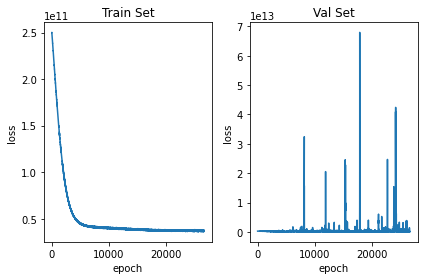

Train Set:
	Mean Emissions Change = 410201.56
	Mean Error = 139745.45
	R Squared = 0.8774
Val Set:
	Mean Emissions Change = 417448.88
	Mean Error = 278848.25
	R Squared = 0.6001
best R Squared seen on epoch 17723: 0.8486


In [23]:
hidden_dims = [512,256]
lr = .01
weight_decay = .01
dropout_p = 0.5

loss_function = nn.MSELoss()
save_prefix = "whitened_base6_dE1_2_no_bottleneck"

best_model_path = train_model_with_params(train_x, val_x, train_y, val_y, n_out, hidden_dims, lr, weight_decay, dropout_p,
                                          loss_function, save_prefix, epochs=80000)

## Inference on all data

In [ ]:
## below we can load specific models instead of best one found in most recent experiment

## best model with no invalids on train/val and no bias
# best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l2_output_reg/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=10000.0,MDF_reg=10000.0"
# model_file = "epoch=38122,r2=0.8806,Invalids=0.pth"
# best_model_path = f"{best_model_dir}/{model_file}"

# # best model with no invalids on train/val with bias
# best_model_dir = "drive/MyDrive/NN_MEFs/FF_models/l1_output_reg_and_bias/hidden=512,256,LR=0.001,w_decay=0.01,dropout=0.5,MEF_reg=1000000.0,MDF_reg=1000000.0,bias=True"
# model_file = "epoch=36772,r2=0.8805,Invalids=0.pth"
# best_model_path = f"{best_model_dir}/{model_file}"



In [ ]:
hidden_dims = [512,256]
bias_term = True
dropout_p = 0.5
n_input = train_x.shape[1]


model = get_model(n_input, hidden_dims, n_out, dropout_p)
model.to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()

train_pred_coeff = model(train_x.float()).cpu()
val_pred_coeff = model(val_x.float()).cpu()
test_pred_coeff = model(test_x.float()).cpu()

print("R Squared:")
print(f"\tTrain: {r2_score(train_y.detach().numpy(), train_preds.detach().numpy()):.4f}")
print(f"\tVal: {r2_score(val_y.detach().numpy(), val_preds.detach().numpy()):.4f}")
print(f"\tTest: {r2_score(test_y.detach().numpy(), test_preds.detach().numpy()):.4f}")
print("Mean Absolute Error:")
print(f"\tTrain: {mean_absolute_error(train_y.detach().numpy(), train_preds.detach().numpy()):.2f}")
print(f"\tVal: {mean_absolute_error(val_y.detach().numpy(), val_preds.detach().numpy()):.2f}")
print(f"\tTest: {mean_absolute_error(test_y.detach().numpy(), test_preds.detach().numpy()):.2f}")


R Squared:
	Train: 0.8921
	Val: 0.8805
	Test: 0.8755
Mean Absolute Error:
	Train: 131028.76
	Val: 140016.71
	Test: 139890.26
Count Invalid Values Predicted:
	Train: Invalid MEFs=0, Invalid MDFs=0
	Val: Invalid MEFs=0, Invalid MDFs=0
	Test: Invalid MEFs=0, Invalid MDFs=0


### Put the MEFs and MDFs from all sets back together and in order into the original DF for viewing

In [ ]:
all_preds_w_timestamps = list(zip(CAISO_val.index, val_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_train.index, train_pred_coeff.detach().numpy())) \
                        + list(zip(CAISO_test.index, test_pred_coeff.detach().numpy()))
all_preds_w_timestamps.sort(key=lambda pair: pair[0])
all_preds_ordered = np.array([pair[1] for pair in all_preds_w_timestamps])

In [ ]:
all_MEFs_ordered = all_preds_ordered[:,0]
all_MDFs_ordered = all_preds_ordered[:,1]
all_intercepts_ordered = all_preds_ordered[:,2]

In [ ]:
CAISO_Data.loc[:,"MEF"] = all_MEFs_ordered
CAISO_Data.loc[:,"MDF"] = all_MDFs_ordered
if bias_term:
    CAISO_Data.loc[:,"Intercept"] = all_intercepts_ordered

#calculate some error stuff. rn i am thinking R2 is the best measure of error
d_emissions = CAISO_Data.loc[:,'MEF'] * CAISO_Data.loc[:,'delta_Load'] \
            + CAISO_Data.loc[:,'MDF'] * CAISO_Data.loc[:,'delta_VRE']
if bias_term:
    d_emissions += CAISO_Data.loc[:,"Intercept"]
CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions'] = d_emissions
CAISO_Data.loc[:,'Error']=CAISO_Data.loc[:,'Predicted_delta_Total_CO2_Emissions']-CAISO_Data.loc[:,'delta_Total_CO2_Emissions']
CAISO_Data.loc[:,'%_Error']=np.abs(CAISO_Data.loc[:,'Error'])/np.abs(CAISO_Data.loc[:,'delta_Total_CO2_Emissions'])
print("Whole Data Set:")
print(f"\tMean Emissions Change = {np.mean(np.abs(CAISO_Data['delta_Total_CO2_Emissions'])):.2f}")
print(f"\tR Squared = {r2_score(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.4f}")
print(f"\tMean Absolute Error = {mean_absolute_error(CAISO_Data['delta_Total_CO2_Emissions'], CAISO_Data['Predicted_delta_Total_CO2_Emissions']):.2f}")

Whole Data Set:
	Mean Emissions Change = 413165.73
	R Squared = 0.8864
	Mean Absolute Error = 134598.78


In [ ]:
CAISO_Data.head()

,Load,Net Load,Total_CO2_Emissions,Total_SO2_Emissions,Total_NOX_Emissions,VRE,delta_Load,delta_Net_Load,delta_Total_CO2_Emissions,delta_Total_SO2_Emissions,...,Day_of_Week=3,Day_of_Week=4,Day_of_Week=5,Day_of_Week=6,MEF,MDF,Intercept,Predicted_delta_Total_CO2_Emissions,Error,%_Error
2019-01-01 00:00:00,22822.964472,20502.358502,5.103942e+06,425.327933,1632.821698,2320.593616,-1285.054865,-1255.110267,-337029.794143,-24.142180,...,False,False,False,False,370.729431,-350.030640,6396.021973,-459526.000872,-122496.206729,0.363458
2019-01-01 01:00:00,21879.620618,19606.836908,4.867578e+06,404.315852,1557.650531,2272.780097,-944.689268,-896.922625,-243021.833700,-21.594332,...,False,False,False,False,345.051025,-323.291504,6071.847168,-304454.710093,-61432.876394,0.252787
2019-01-01 02:00:00,21257.454020,19056.267637,4.723101e+06,383.695714,1496.197481,2201.182455,-614.641020,-545.206677,-144846.797503,-20.952957,...,False,False,False,False,323.416351,-301.258514,5678.250977,-172189.482236,-27342.684733,0.188770
2019-01-01 03:00:00,20974.800758,18871.418601,4.693112e+06,380.561848,1466.329836,2103.388502,-281.391674,-191.565227,-24776.569759,-2.164379,...,False,False,False,False,305.443024,-282.996887,5341.076660,-55190.639304,-30414.069545,1.227534
2019-01-01 04:00:00,20327.083333,18012.666667,5.032423e+06,711.911968,2391.657870,2314.666667,30.416667,74.416667,49254.136541,69.703951,...,False,False,False,False,303.949066,-272.057770,5023.662109,26216.649928,-23037.486613,0.467727


In [ ]:
CAISO_Data.to_csv(f"{best_model_dir}/CAISO_Data_2019_2021_NN_Ts.with_coeff_preds.csv")

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val <=0])

0

In [ ]:
len([val for val in CAISO_Data.loc[:,"MEF"] if val >600])

53

In [ ]:
CAISO_Data.loc[:,"MEF"].max()

719.43835